# We will test the impact of using a new version of REBOUND to generate data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [2]:
#load datapath for clean training data that is generated
datapath = '../../cleanData/csvs/resonant/'
old = pd.read_csv(datapath+'oldReboundClean.csv')
new = pd.read_csv(datapath+'1e4data.csv')

#remove junk columns
old = old.drop(columns=['Unnamed: 0','Unnamed: 0.1'])
new = new.drop(columns=['Unnamed: 0','Unnamed: 0.1'])


In [3]:

def train_test(dataset,features):
    '''divides the dataset into 80% training and 20% testing and returns training/testing sets'''
    Nrows = int(0.8*dataset.shape[0])
    train = dataset.iloc[:Nrows, :]
    test = dataset.iloc[Nrows:, :]
    #remove testing systems that go unstable in 1e4 orbits

    test = test.drop(test[test['InitialStable']==False].index)
    return train[features], train['Stable'], test[features], test['Stable']

In [4]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno

trainXO, trainYO, testXO, testYO = train_test(old, features)
trainXN, trainYN, testXN, testYN = train_test(new, features)

In [5]:
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, auc
def ROC_curve( model, x,y):
    preds = model.predict_proba(x)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = metrics.roc_auc_score(y, preds)
    return roc_auc, fpr, tpr, ROCthresholds

In [6]:
modelO = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 13, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 100,
                         )
modelN = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 13, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 100,
                         )

In [7]:
modelO.fit(trainXO,trainYO)
modelN.fit(trainXN, trainYN)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# Comparison

Text(0.5, 1.0, 'ROC curve using old rebound (AUC = 0.942)')

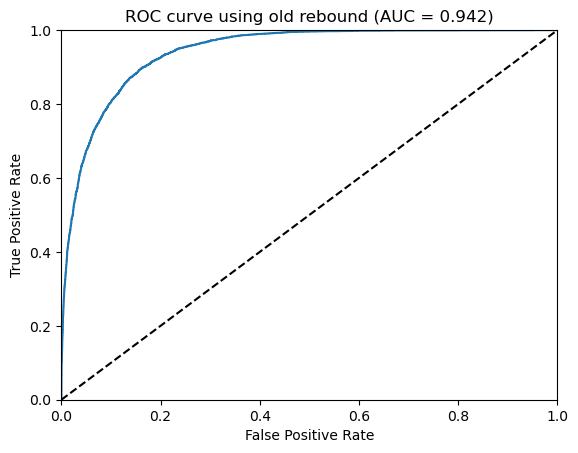

In [10]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(modelO, testXO, testYO)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve using old rebound (AUC = {0:.3f})'.format(roc_auc))

In [11]:
print("Old rebound AUC")
print(roc_auc)

Old rebound AUC
0.9418648287130079


Text(0.5, 1.0, 'ROC curve using new rebound (AUC = 0.942)')

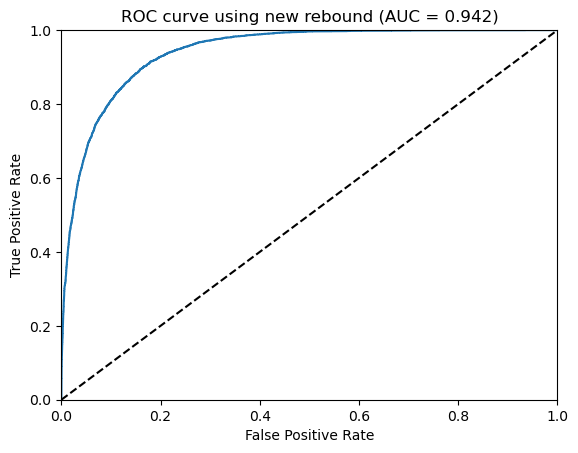

In [12]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(modelN, testXN, testYN)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve using new rebound (AUC = {0:.3f})'.format(roc_auc))

In [13]:
print("Old rebound AUC")
print(roc_auc)

Old rebound AUC
0.9420735015804043


# Results
Updated rebound with updated MEGNO calculations has little impact on model